## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
import os

In [76]:
mylist= os.listdir('RawData/')

In [77]:
type(mylist)

list

In [78]:
print(mylist[1800])

f01 (10).wav


In [79]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [80]:
data, sampling_rate = librosa.load('RawData/f11 (2).wav')

Populating the interactive namespace from numpy and matplotlib


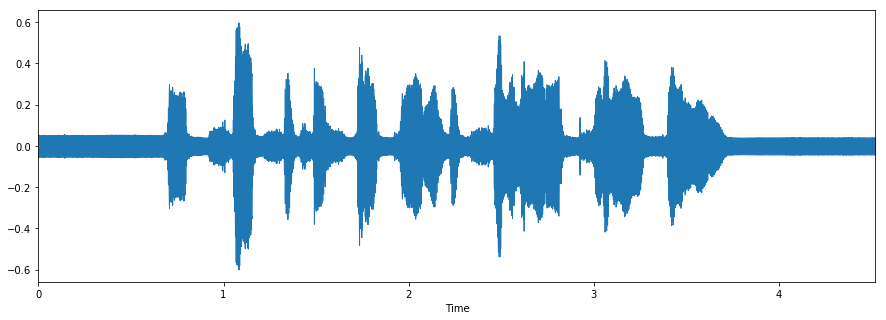

In [82]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

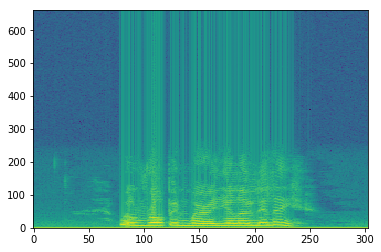

In [83]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [84]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [85]:
labels = pd.DataFrame(feeling_list)

In [86]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [87]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [132]:
df[:5]

,feature
0,"[-70.2677641611, -70.2677641611, -70.267764161..."
1,"[-65.7076524007, -65.7076524007, -63.114722422..."
2,"[-65.4824988827, -65.4824988827, -65.482498882..."
3,"[-64.5284491035, -64.5284491035, -64.528449103..."
4,"[-62.3643105275, -59.9347251381, -61.869599961..."


In [89]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [90]:
df3[:5]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-58.802037,-57.447461,-58.896493,-58.751002,-57.405669,-60.078475,-63.426811,-62.638537,-61.116223,-60.357015
1,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,...,-38.301204,-39.792147,-40.613166,-41.209201,-41.439204,-43.994282,-49.399616,-50.591601,-49.146184,-48.687893
2,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,...,-29.193261,-31.346553,-34.310774,-35.800705,-35.936112,-37.631846,-40.119408,-41.662903,-41.333382,-40.721261
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.872007,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.512184,-43.644038
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-33.817362,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.386896,-44.065982


In [91]:
newdf = pd.concat([df3,labels], axis=1)

In [92]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [93]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-57.447461,-58.896493,-58.751002,-57.405669,-60.078475,-63.426811,-62.638537,-61.116223,-60.357015,male_calm
1,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,...,-39.792147,-40.613166,-41.209201,-41.439204,-43.994282,-49.399616,-50.591601,-49.146184,-48.687893,female_calm
2,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,...,-31.346553,-34.310774,-35.800705,-35.936112,-37.631846,-40.119408,-41.662903,-41.333382,-40.721261,male_calm
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.512184,-43.644038,female_calm
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.386896,-44.065982,male_calm


In [94]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
21,-61.308326,-61.715255,-63.512867,-61.015363,-58.811008,-57.962848,-57.511399,-57.648689,-59.732432,-61.305005,...,-59.425273,-59.087587,-61.430003,-66.197771,-64.429329,-59.176353,-56.783175,-58.189525,-62.488644,female_calm
1323,-22.361701,-23.183582,-23.462845,-22.702523,-21.286161,-21.224313,-20.588523,-20.409861,-20.913503,-20.004418,...,-9.785634,-10.987327,-9.716262,-8.282137,-8.344835,-10.647344,-9.888029,-8.180361,-7.387702,male_happy
72,-69.051400,-69.051400,-69.051400,-69.051400,-69.051400,-68.754863,-69.051400,-69.051400,-69.051400,-68.359101,...,-57.681647,-56.301264,-58.650128,-63.881082,-63.749409,-65.222466,-65.308242,-67.008563,-68.636299,male_calm
1522,-24.097256,-24.047160,-24.009617,-24.403762,-24.113488,-24.205047,-23.358246,-23.634424,-25.200700,-25.676273,...,-12.351449,-12.171340,-11.013329,-12.121563,-12.318888,-12.928231,-13.243706,-15.338297,-15.992746,male_sad
1639,-24.258893,-24.370455,-25.136586,-24.604011,-24.346176,-25.428182,-25.034438,-25.761060,-25.710213,-25.178202,...,-17.541456,-18.140994,-17.731916,-9.786449,-8.568349,-9.406496,-10.584285,-14.363349,-20.225258,male_sad
1201,-24.926267,-23.169811,-21.245199,-21.962838,-21.155641,-19.976974,-19.039640,-18.584071,-17.458343,-18.494908,...,-2.104808,-2.371538,-2.920319,-3.980816,-4.175833,-4.156463,-5.025786,-7.165411,-8.216455,male_fearful
595,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,...,-66.730016,-66.730016,-66.659748,-66.092053,-66.427894,-66.730016,-66.561697,-65.294555,-65.872494,female_angry
341,-38.217409,-41.892889,-44.717843,-45.231656,-46.388265,-46.609081,-46.288274,-45.191871,-45.330696,-45.295944,...,-42.721089,-43.540027,-43.351807,-43.272884,-43.244743,-44.006233,-44.455662,-43.264436,-40.820973,female_happy
1556,-27.733099,-25.317773,-24.269950,-25.217025,-24.375727,-23.234039,-23.060856,-23.593578,-25.465050,-24.390285,...,-19.613746,-22.958603,-22.451133,-22.969600,-24.166463,-23.357229,-23.805899,-22.046549,-21.264596,male_sad
1408,3.613954,0.370077,-5.980664,-5.950784,-6.713028,-7.503217,-5.824622,-4.414467,-4.557089,-4.100681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_happy


In [95]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [96]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [97]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1565,-25.501792,-26.071097,-28.139215,-28.083108,-29.027153,-29.084228,-29.444832,-28.174279,-26.825199,-25.776648,...,-28.675121,-28.234779,-28.040587,-28.183097,-27.638088,-28.436068,-29.349459,-31.348238,-32.599974,male_sad
352,-42.612174,-44.166237,-46.185036,-44.702588,-42.975322,-44.313460,-44.428072,-44.274411,-43.780628,-43.182182,...,-39.133879,-39.412003,-37.711996,-39.044554,-38.289962,-38.845617,-40.895972,-42.263709,-41.276468,male_happy
337,-53.381730,-53.180815,-52.933302,-53.063797,-53.269084,-52.884994,-53.325040,-52.097120,-50.897439,-51.841784,...,-53.181291,-53.471820,-53.331062,-53.277394,-53.471820,-53.471820,-53.471820,-53.471820,-53.471820,female_happy
1557,-31.908893,-29.785277,-29.312566,-29.340708,-29.309514,-31.234801,-31.892522,-29.230806,-26.412683,-25.962694,...,-28.468336,-29.646353,-28.075079,-28.881573,-28.615487,-28.692476,-28.945379,-26.115368,-24.266730,male_sad
142,-67.997873,-67.997873,-67.997873,-67.997873,-67.901045,-65.704135,-66.570574,-67.737900,-67.997873,-67.997873,...,-25.700011,-24.859504,-23.396612,-21.860789,-22.140767,-21.855355,-23.117520,-21.937875,-19.853739,male_calm
1611,-28.023489,-27.012539,-24.843077,-26.073845,-26.605960,-25.415706,-26.137463,-25.882579,-26.144014,-25.486000,...,-9.060266,-10.795528,-11.224794,-10.564187,-10.653920,-10.423875,-10.612708,-9.730200,-6.192753,male_sad
1312,6.513997,2.688604,-14.524403,-16.414605,-16.501808,-15.895883,-18.425453,-18.493186,-19.697174,-20.406525,...,-18.862519,-20.383509,-19.070432,-18.314215,-18.376352,-18.308258,-15.165213,-6.792507,-0.884134,male_fearful
174,-67.851589,-68.222956,-71.009622,-71.753631,-68.483130,-66.897252,-68.951866,-71.381363,-74.111062,-75.449917,...,-29.047171,-28.798121,-29.476985,-29.069542,-29.336515,-29.969129,-30.079989,-26.872842,-23.062258,male_calm
1561,-26.477874,-21.849877,-11.200553,-6.713980,-5.940031,-6.923090,-7.600638,-7.370041,-7.653199,-9.667168,...,-7.755277,-6.800155,-6.931997,-8.070164,-6.287150,-5.732645,-5.968971,-2.897270,-0.117555,male_sad
224,-57.338221,-59.334333,-59.049307,-60.715965,-62.138004,-60.609590,-60.180352,-60.997297,-61.306802,-61.226960,...,-52.162158,-52.850261,-52.955079,-52.390493,-48.519363,-46.721866,-48.350662,-53.439951,-51.079765,male_happy


In [98]:
trainfeatures = train.iloc[:, :-1]

In [99]:
trainlabel = train.iloc[:, -1:]

In [100]:
testfeatures = test.iloc[:, :-1]

In [101]:
testlabel = test.iloc[:, -1:]

In [102]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [103]:
y_train

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [104]:
X_train.shape

(1361, 216)

## Padding sequence for CNN model

In [105]:
print('Pad sequences')
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

Pad sequences


In [106]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [107]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 216, 128)          768       
_________________________________________________________________
activation_8 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 216, 128)          82048     
_________________________________________________________________
activation_9 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 27, 128)           82048     
__________

In [108]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [109]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=1009, validation_data=(x_testcnn, y_test))

Train on 1361 samples, validate on 319 samples
Epoch 1/1009
1361/1361 [==============================] - 2s - loss: 2.7253 - acc: 0.1624 - val_loss: 2.3087 - val_acc: 0.1567
Epoch 2/1009
1361/1361 [==============================] - 0s - loss: 2.3247 - acc: 0.1602 - val_loss: 2.2614 - val_acc: 0.2038
Epoch 3/1009
1361/1361 [==============================] - 0s - loss: 2.2570 - acc: 0.1852 - val_loss: 2.2339 - val_acc: 0.1912
Epoch 4/1009
1361/1361 [==============================] - 0s - loss: 2.2391 - acc: 0.1918 - val_loss: 2.2162 - val_acc: 0.2038
Epoch 5/1009
1361/1361 [==============================] - 0s - loss: 2.1939 - acc: 0.2182 - val_loss: 2.1911 - val_acc: 0.1912
Epoch 6/1009
1361/1361 [==============================] - 0s - loss: 2.1820 - acc: 0.2013 - val_loss: 2.1697 - val_acc: 0.1881
Epoch 7/1009
1361/1361 [==============================] - 0s - loss: 2.1516 - acc: 0.2050 - val_loss: 2.1374 - val_acc: 0.1975
Epoch 8/1009
1361/1361 [==============================] - 0s - l

1361/1361 [==============================] - 0s - loss: 1.0085 - acc: 0.6429 - val_loss: 1.0938 - val_acc: 0.6144
Epoch 128/1009
1361/1361 [==============================] - 0s - loss: 1.0124 - acc: 0.6392 - val_loss: 1.1321 - val_acc: 0.6019
Epoch 129/1009
1361/1361 [==============================] - 0s - loss: 1.0331 - acc: 0.6238 - val_loss: 1.1117 - val_acc: 0.6019
Epoch 130/1009
1361/1361 [==============================] - 0s - loss: 1.0176 - acc: 0.6267 - val_loss: 1.0882 - val_acc: 0.6207
Epoch 131/1009
1361/1361 [==============================] - 0s - loss: 1.0001 - acc: 0.6466 - val_loss: 1.0886 - val_acc: 0.6144
Epoch 132/1009
1361/1361 [==============================] - 0s - loss: 0.9967 - acc: 0.6392 - val_loss: 1.0934 - val_acc: 0.6207
Epoch 133/1009
1361/1361 [==============================] - 0s - loss: 0.9937 - acc: 0.6510 - val_loss: 1.0827 - val_acc: 0.6082
Epoch 134/1009
1361/1361 [==============================] - 0s - loss: 0.9986 - acc: 0.6436 - val_loss: 1.0785 -

1361/1361 [==============================] - 0s - loss: 0.6847 - acc: 0.7663 - val_loss: 0.8874 - val_acc: 0.6897
Epoch 254/1009
1361/1361 [==============================] - 0s - loss: 0.6809 - acc: 0.7583 - val_loss: 0.8624 - val_acc: 0.6897
Epoch 255/1009
1361/1361 [==============================] - 0s - loss: 0.6814 - acc: 0.7634 - val_loss: 0.8670 - val_acc: 0.7053
Epoch 256/1009
1361/1361 [==============================] - 0s - loss: 0.6604 - acc: 0.7722 - val_loss: 0.9022 - val_acc: 0.6991
Epoch 257/1009
1361/1361 [==============================] - 0s - loss: 0.6705 - acc: 0.7708 - val_loss: 0.8620 - val_acc: 0.6991
Epoch 258/1009
1361/1361 [==============================] - 0s - loss: 0.6817 - acc: 0.7605 - val_loss: 0.8646 - val_acc: 0.7053
Epoch 259/1009
1361/1361 [==============================] - 0s - loss: 0.6660 - acc: 0.7693 - val_loss: 0.8698 - val_acc: 0.6959
Epoch 260/1009
1361/1361 [==============================] - 0s - loss: 0.6630 - acc: 0.7708 - val_loss: 0.8758 -

1361/1361 [==============================] - 0s - loss: 0.4773 - acc: 0.8317 - val_loss: 0.8411 - val_acc: 0.7147
Epoch 380/1009
1361/1361 [==============================] - 0s - loss: 0.4716 - acc: 0.8523 - val_loss: 0.8088 - val_acc: 0.7022
Epoch 381/1009
1361/1361 [==============================] - 0s - loss: 0.4685 - acc: 0.8472 - val_loss: 0.8116 - val_acc: 0.7179
Epoch 382/1009
1361/1361 [==============================] - 0s - loss: 0.4906 - acc: 0.8361 - val_loss: 0.8274 - val_acc: 0.7085
Epoch 383/1009
1361/1361 [==============================] - 0s - loss: 0.4695 - acc: 0.8464 - val_loss: 0.8019 - val_acc: 0.7179
Epoch 384/1009
1361/1361 [==============================] - 0s - loss: 0.4652 - acc: 0.8347 - val_loss: 0.8043 - val_acc: 0.7179
Epoch 385/1009
1361/1361 [==============================] - 0s - loss: 0.4571 - acc: 0.8413 - val_loss: 0.8556 - val_acc: 0.7022
Epoch 386/1009
1361/1361 [==============================] - 0s - loss: 0.4676 - acc: 0.8339 - val_loss: 0.8089 -

1361/1361 [==============================] - 0s - loss: 0.3231 - acc: 0.8868 - val_loss: 0.8897 - val_acc: 0.7085
Epoch 506/1009
1361/1361 [==============================] - 0s - loss: 0.3366 - acc: 0.8868 - val_loss: 0.8159 - val_acc: 0.7210
Epoch 507/1009
1361/1361 [==============================] - 0s - loss: 0.3054 - acc: 0.9023 - val_loss: 0.8267 - val_acc: 0.7179
Epoch 508/1009
1361/1361 [==============================] - 0s - loss: 0.3267 - acc: 0.8993 - val_loss: 0.8328 - val_acc: 0.7304
Epoch 509/1009
1361/1361 [==============================] - 0s - loss: 0.3108 - acc: 0.9001 - val_loss: 0.7982 - val_acc: 0.7241
Epoch 510/1009
1361/1361 [==============================] - 0s - loss: 0.3048 - acc: 0.9052 - val_loss: 0.7975 - val_acc: 0.7273
Epoch 511/1009
1361/1361 [==============================] - 0s - loss: 0.3149 - acc: 0.9074 - val_loss: 0.8375 - val_acc: 0.7273
Epoch 512/1009
1361/1361 [==============================] - 0s - loss: 0.3165 - acc: 0.8920 - val_loss: 0.8927 -

1361/1361 [==============================] - 0s - loss: 0.1991 - acc: 0.9383 - val_loss: 0.9210 - val_acc: 0.7179
Epoch 632/1009
1361/1361 [==============================] - 0s - loss: 0.1915 - acc: 0.9398 - val_loss: 0.9021 - val_acc: 0.7304
Epoch 633/1009
1361/1361 [==============================] - 0s - loss: 0.1955 - acc: 0.9449 - val_loss: 0.9116 - val_acc: 0.7116
Epoch 634/1009
1361/1361 [==============================] - 0s - loss: 0.2012 - acc: 0.9295 - val_loss: 0.8888 - val_acc: 0.7273
Epoch 635/1009
1361/1361 [==============================] - 0s - loss: 0.1888 - acc: 0.9471 - val_loss: 0.9191 - val_acc: 0.7210
Epoch 636/1009
1361/1361 [==============================] - 0s - loss: 0.1972 - acc: 0.9361 - val_loss: 0.9140 - val_acc: 0.7179
Epoch 637/1009
1361/1361 [==============================] - 0s - loss: 0.1895 - acc: 0.9471 - val_loss: 0.8924 - val_acc: 0.7116
Epoch 638/1009
1361/1361 [==============================] - 0s - loss: 0.1978 - acc: 0.9353 - val_loss: 0.8798 -

1361/1361 [==============================] - 0s - loss: 0.0999 - acc: 0.9772 - val_loss: 1.0308 - val_acc: 0.7022
Epoch 758/1009
1361/1361 [==============================] - 0s - loss: 0.1086 - acc: 0.9713 - val_loss: 1.0657 - val_acc: 0.7147
Epoch 759/1009
1361/1361 [==============================] - 0s - loss: 0.1013 - acc: 0.9743 - val_loss: 1.0193 - val_acc: 0.7147
Epoch 760/1009
1361/1361 [==============================] - 0s - loss: 0.1010 - acc: 0.9735 - val_loss: 1.0364 - val_acc: 0.7116
Epoch 761/1009
1361/1361 [==============================] - 0s - loss: 0.1051 - acc: 0.9699 - val_loss: 1.0108 - val_acc: 0.7179
Epoch 762/1009
1361/1361 [==============================] - 0s - loss: 0.1020 - acc: 0.9721 - val_loss: 0.9940 - val_acc: 0.7241
Epoch 763/1009
1361/1361 [==============================] - 0s - loss: 0.1029 - acc: 0.9728 - val_loss: 1.0582 - val_acc: 0.7116
Epoch 764/1009
1361/1361 [==============================] - 0s - loss: 0.1086 - acc: 0.9713 - val_loss: 1.0082 -

1361/1361 [==============================] - 0s - loss: 0.0589 - acc: 0.9853 - val_loss: 1.1862 - val_acc: 0.7210
Epoch 884/1009
1361/1361 [==============================] - 0s - loss: 0.0565 - acc: 0.9860 - val_loss: 1.1324 - val_acc: 0.7210
Epoch 885/1009
1361/1361 [==============================] - 0s - loss: 0.0504 - acc: 0.9912 - val_loss: 1.1815 - val_acc: 0.7085
Epoch 886/1009
1361/1361 [==============================] - 0s - loss: 0.0572 - acc: 0.9890 - val_loss: 1.1292 - val_acc: 0.7053
Epoch 887/1009
1361/1361 [==============================] - 0s - loss: 0.0559 - acc: 0.9897 - val_loss: 1.1470 - val_acc: 0.7179
Epoch 888/1009
1361/1361 [==============================] - 0s - loss: 0.0461 - acc: 0.9904 - val_loss: 1.1633 - val_acc: 0.7116
Epoch 889/1009
1361/1361 [==============================] - 0s - loss: 0.0504 - acc: 0.9912 - val_loss: 1.1363 - val_acc: 0.7210
Epoch 890/1009
1361/1361 [==============================] - 0s - loss: 0.0599 - acc: 0.9838 - val_loss: 1.1471 -

1361/1361 [==============================] - 0s - loss: 0.0247 - acc: 0.9956 - val_loss: 1.3213 - val_acc: 0.7273


## Plotting the accuracy and loss graph

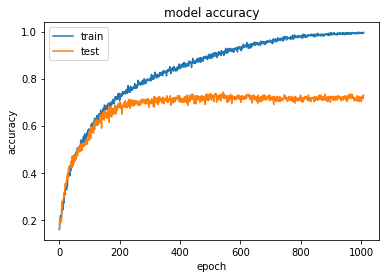

In [110]:
#sigmoid
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

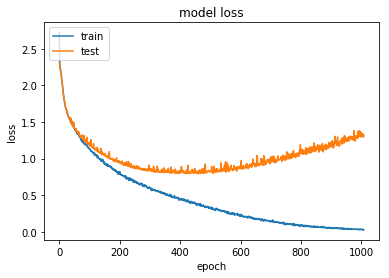

In [111]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [112]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\mites\Documents\Cognitive\Final Exam\saved_models\Emotion_Voice_Detection_Model.h5 


## Predicting emotions on the test data

In [113]:
preds = model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

319/319 [==============================] - 0s     


In [114]:
preds

array([[  3.49815641e-12,   1.18043589e-10,   1.13181663e-19, ...,
          1.80016723e-05,   7.36836637e-06,   1.14132257e-04],
       [  3.87504338e-16,   5.73074694e-23,   1.31673211e-14, ...,
          1.75147681e-04,   1.85760673e-05,   9.99805748e-01],
       [  8.39285008e-07,   3.43896300e-11,   5.38965035e-03, ...,
          9.93317604e-01,   1.99900052e-04,   1.05243188e-03],
       ..., 
       [  3.49616457e-04,   1.94651744e-04,   6.65218568e-06, ...,
          1.67340226e-02,   6.44345134e-02,   9.10043001e-01],
       [  4.23396705e-06,   1.59581254e-11,   6.03030126e-12, ...,
          6.36715861e-03,   9.64888096e-01,   2.34207995e-02],
       [  3.69524572e-31,   0.00000000e+00,   0.00000000e+00, ...,
          5.24333927e-07,   9.99998808e-01,   6.36476927e-10]], dtype=float32)

In [115]:
preds1=preds.argmax(axis=1)

In [116]:
preds1

array([6, 9, 7, 1, 7, 8, 1, 2, 5, 8, 7, 1, 9, 9, 4, 0, 5, 0, 5, 8, 4, 1, 5,
       9, 7, 5, 7, 1, 7, 5, 8, 1, 8, 9, 2, 2, 1, 8, 6, 0, 5, 9, 1, 0, 7, 5,
       5, 7, 7, 0, 0, 7, 0, 0, 6, 5, 3, 7, 5, 8, 5, 4, 8, 8, 9, 7, 2, 8, 6,
       1, 5, 6, 8, 6, 5, 3, 4, 8, 8, 9, 9, 0, 8, 9, 4, 5, 0, 0, 5, 5, 7, 9,
       4, 7, 8, 6, 9, 5, 6, 8, 1, 7, 0, 8, 8, 7, 3, 2, 7, 8, 7, 9, 7, 9, 5,
       7, 8, 6, 0, 1, 6, 9, 1, 5, 8, 7, 1, 8, 6, 9, 3, 7, 7, 4, 6, 5, 8, 8,
       1, 0, 5, 0, 7, 6, 5, 7, 4, 9, 2, 5, 4, 7, 5, 6, 8, 5, 5, 4, 8, 8, 2,
       7, 5, 7, 6, 9, 8, 9, 9, 0, 2, 5, 7, 8, 3, 0, 4, 6, 6, 9, 9, 9, 3, 8,
       1, 7, 2, 5, 8, 1, 8, 4, 4, 8, 5, 2, 9, 9, 5, 6, 0, 5, 9, 0, 8, 7, 4,
       6, 6, 3, 9, 5, 9, 6, 1, 7, 5, 7, 8, 4, 9, 2, 5, 6, 6, 4, 2, 1, 8, 2,
       7, 5, 7, 3, 5, 6, 8, 7, 1, 6, 0, 0, 4, 7, 4, 4, 4, 4, 4, 0, 8, 1, 6,
       7, 4, 8, 7, 8, 2, 9, 6, 2, 7, 8, 3, 9, 9, 7, 2, 5, 7, 2, 9, 5, 5, 7,
       8, 5, 6, 8, 1, 2, 5, 9, 4, 5, 5, 6, 7, 8, 7, 0, 9, 5, 9, 5, 9, 7, 8,
       1, 2,

In [117]:
abc = preds1.astype(int).flatten()

In [118]:
predictions = (lb.inverse_transform((abc)))

In [119]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_calm
4,male_fearful
5,male_happy
6,female_calm
7,female_fearful
8,male_angry
9,male_happy


In [120]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [121]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_fearful
4,male_fearful
5,male_happy
6,female_calm
7,female_angry
8,male_angry
9,male_happy


In [122]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [128]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_fearful
171,male_angry,male_angry
172,male_fearful,male_fearful
173,male_happy,male_happy
174,female_happy,female_happy
175,female_angry,female_angry
176,female_angry,female_sad
177,male_sad,male_calm
178,male_angry,male_calm
179,male_sad,male_sad


In [129]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,20
female_fearful,19
female_happy,17
female_sad,20
male_angry,55
male_calm,25
male_fearful,55
male_happy,49


In [130]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_calm,22
female_fearful,19
female_happy,9
female_sad,25
male_angry,51
male_calm,29
male_fearful,51
male_happy,50


In [131]:
finaldf.to_csv('Predictions.csv', index=False)